In [3]:
import seaborn as sns
from math import sqrt
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import time
from sklearn.impute import KNNImputer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

In [30]:
class Model_LSTM:
    def __init__(self, variables, start_date, look_back, target_index=0):
        self.variables = variables
        self.start_date = start_date
        self.end_date = datetime.date.today()
        self.look_back = look_back
        self.target_index = target_index
        self.model = None
        self.n_features = len(variables)

    def load_data(self):
        end_date_str = self.end_date.strftime('%Y-%m-%d')
        data_history = yf.download(self.variables, start=self.start_date, end=end_date_str)['Close']
        return data_history
    
    def imputer_data(self, data_history):
        imputer = KNNImputer(n_neighbors=2, weights="distance")
        data_unifor = imputer.fit_transform(data_history)
        data = pd.DataFrame(data_unifor, columns=data_history.columns, index=data_history.index)
        return data

    def preprocess_data(self, data):
        data_diff = np.log(data / data.shift(1))
        data_diff = data_diff.dropna()
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_scaled = scaler.fit_transform(data_diff.values)
        return data_scaled, scaler

    def create_dataset(self, dataset):
        data_x, data_y = [], []
        for i in range(self.look_back, len(dataset)):
            data_x.append(dataset[i - self.look_back:i, :])
            data_y.append(dataset[i, self.target_index])
        return np.array(data_x), np.array(data_y)

    def split_data(self, X, y, train_ratio=0.8):
        train_size = int(len(X) * train_ratio)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        return X_train, X_test, y_train, y_test

    def build_model(self, units, dropout_rate, dense_units, learning_rate, activation):
        model = Sequential()
        model.add(LSTM(units, activation=activation, dropout=dropout_rate,
                       recurrent_dropout=dropout_rate, input_shape=(self.look_back, self.n_features)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(dense_units, activation=activation))
        model.add(Dense(1))
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        self.model = model
        return model

    def train_model(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
        history = self.model.fit(X_train, y_train,
                                 validation_data=(X_val, y_val),
                                 epochs=epochs, batch_size=batch_size,
                                 callbacks=callbacks, verbose=2)
        return history

    def plot_training_history(self, history):
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Training History')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def evaluate_model(self, X_test, y_test):
        predictions = self.model.predict(X_test)
        mae = sqrt(mean_absolute_error(y_test, predictions))
        rmse = sqrt(mean_squared_error(y_test, predictions))
        print(f"Test MAE: {rmse:.4f}")
        print(f"Test MAE: {mae:.4f}")
        return predictions, rmse

    def save_model(self, path='lstm_model.h5'):
        if self.model:
            self.model.save(path)

    def load_model(self, path='lstm_model.h5'):
        self.model = tf.keras.models.load_model(path)

In [31]:
model = Model_LSTM(variables=[ "^GSPC", "^DJI", "^IXIC", "^RUT", "PL=F",
    "EURUSD=X", "JPY=X", "CAD=X", "UUP", "^TNX", "^IRX", "TLT",
    "CL=F", "GC=F", "BZ=F", "^GDAXI", "^FTSE", "^N225",
    "XRT", "XLK", "XLF", "SI=F", "AUDUSD=X", "^N100", 
    "^IBEX", "^FCHI", "^HSI", "^TWII", "BTC-USD"],
                   start_date='2017-01-01',
                   look_back=20,
                   target_index=19)

In [32]:
data = model.load_data()

[*********************100%***********************]  29 of 29 completed


In [33]:
data_imputed = model.imputer_data(data)
data_scaled, scaler = model.preprocess_data(data_imputed)
X, y = model.create_dataset(data_scaled)
X_train, X_test, y_train, y_test = model.split_data(X, y)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [23]:
print(f"X_train shape: {X_train.shape}")  # debería ser (n_samples, 24, n_features)
print(f"y_train shape: {y_train.shape}")
print(f"y_train shape: {X_test.shape}")
print(f"y_train shape: {y_test.shape}")

X_train shape: (2404, 20, 29)
y_train shape: (2404,)
y_train shape: (602, 20, 29)
y_train shape: (602,)


In [34]:
units = 256
dropout_rate = 0.2
dense_units = 64
learning_rate = 0.0019900608121585874
activation = 'tanh'

In [35]:
modelo = model.build_model(units, dropout_rate, dense_units, learning_rate, activation)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
history = model.train_model(X_train, y_train, X_val = X_test, y_val = y_test, epochs=40, batch_size=64)

Epoch 1/40
38/38 - 5s - 135ms/step - loss: 0.1122 - val_loss: 0.0075
Epoch 2/40
38/38 - 2s - 62ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 3/40
38/38 - 3s - 68ms/step - loss: 0.0086 - val_loss: 0.0054
Epoch 4/40
38/38 - 3s - 67ms/step - loss: 0.0078 - val_loss: 0.0054
Epoch 5/40
38/38 - 2s - 63ms/step - loss: 0.0075 - val_loss: 0.0053
Epoch 6/40
38/38 - 2s - 62ms/step - loss: 0.0075 - val_loss: 0.0057
Epoch 7/40
38/38 - 2s - 62ms/step - loss: 0.0071 - val_loss: 0.0052
Epoch 8/40
38/38 - 2s - 62ms/step - loss: 0.0068 - val_loss: 0.0058
Epoch 9/40
38/38 - 2s - 62ms/step - loss: 0.0070 - val_loss: 0.0053
Epoch 10/40
38/38 - 2s - 61ms/step - loss: 0.0066 - val_loss: 0.0052
Epoch 11/40
38/38 - 2s - 63ms/step - loss: 0.0062 - val_loss: 0.0052
Epoch 12/40
38/38 - 2s - 61ms/step - loss: 0.0065 - val_loss: 0.0051
Epoch 13/40
38/38 - 2s - 61ms/step - loss: 0.0064 - val_loss: 0.0054
Epoch 14/40
38/38 - 2s - 62ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 15/40
38/38 - 2s - 60ms/step - loss:

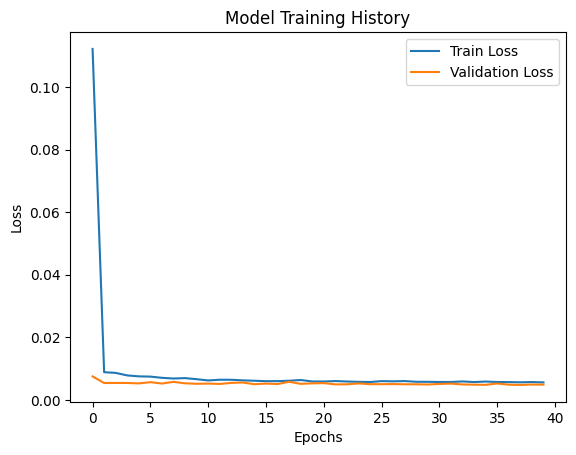

In [37]:
model.plot_training_history(history)

In [38]:
predictions = model.evaluate_model(X_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Test MAE: 0.0693
Test MAE: 0.1888
